# Plotting for results

This notebook produces all results plots.
It generates some gap in the data, fill with a method (filter, MDS ...), compute metrics and then makes all relevant plots

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import altair as alt

In [ ]:
from meteo_imp.kalman.results import *
from meteo_imp.data import *
from meteo_imp.utils import *
import pandas as pd
import numpy as np
from pyprojroot import here
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG, Image

In [ ]:
import vl_convert as vlc
from pyprojroot import here
base_path_img = here("manuscript/Master Thesis - Meteorological time series imputation using Kalman filters - Simone Massaro/images2/")
base_path_tbl = here("manuscript/Master Thesis - Meteorological time series imputation using Kalman filters - Simone Massaro/tables2/")

base_path_img.mkdir(exist_ok=True), base_path_tbl.mkdir(exist_ok=True)

def save_plot(plot, path):
    png_data = vlc.vegalite_to_png(vl_spec=plot.to_json(), scale=3)
    with open(base_path_img / (path + ".png"), "wb") as f:
        f.write(png_data)

def show_plot(path): return Image(filename=base_path_img / (path + ".png"))

In [ ]:
reset_seed()
n_rep = 500

In [ ]:
hai = pd.read_parquet(hai_big_path).reindex(columns=var_type.categories)
hai_era = pd.read_parquet(hai_era_big_path)

In [ ]:
hai.P.std()

0.28027581235432886

In [ ]:
np.sqrt(hai.P.pow(2).mean())

0.28361957122093423

## Comparison Imputation methods

In [ ]:
base_path_old = here("analysis/results/trained_14feb")
base_path = here("analysis/results/trained_21feb")

In [ ]:
def l_model(x, base_path=base_path): return torch.load(base_path / x)

In [ ]:
models_var_old = [
    {'var': 'TA',    'model': l_model("TA_specialized_gap_12-336_v2.pickle.pickle",base_path_old )},
    {'var': 'SW_IN', 'model': l_model("SW_IN_specialized_gap_12-336_v2.pickle.pickle",base_path_old )},
    {'var': 'LW_IN', 'model': l_model("LW_IN_specialized_gap_12-336_v1.pickle",base_path_old )},
    {'var': 'VPD',   'model': l_model("VPD_specialized_gap_12-336_v1.pickle",base_path_old )},
    {'var': 'WS',    'model': l_model("WS_specialized_gap_12-336_v3.pickle",base_path_old )},
    {'var': 'PA',    'model': l_model("PA_specialized_gap_12-336_v3.pickle",base_path_old )},
    {'var': 'P',     'model': l_model("P_specialized_gap_12-336_v1.pickle",base_path_old )},
    {'var': 'TS',    'model': l_model("TS_specialized_gap_12-336_v3.pickle",base_path_old )},
    {'var': 'SWC',   'model': l_model("SWC_specialized_gap_12-336_v3_4.pickle",base_path_old )},
]
models_var_old = pd.DataFrame.from_records(models_var_old)

In [ ]:
models_var = [
    {'var': 'TA',    'model': l_model("TA_specialized_gap_6-336_v3_0.pickle",base_path)},
    {'var': 'SW_IN', 'model': l_model("SW_IN_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'LW_IN', 'model': l_model("LW_IN_specialized_gap_6-336_v1.pickle",base_path)},
    {'var': 'VPD',   'model': l_model("VPD_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'WS',    'model': l_model("WS_specialized_gap_6-336_v1.pickle",base_path)},
    {'var': 'PA',    'model': l_model("PA_specialized_gap_6-336_v3_0.pickle",base_path)},
    {'var': 'P',     'model': l_model("1_gap_varying_6-336_v3.pickle",base_path)},
    {'var': 'TS',    'model': l_model("TS_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'SWC',   'model': l_model("SWC_specialized_gap_6-336_v2_1.pickle",base_path)},
]
models_var = pd.DataFrame.from_records(models_var)

### Old vs new

In [ ]:
models_old_new = pd.concat([models_var.assign(version='new'), models_var_old.assign(version='old')])

In [ ]:
@cache_disk("new_old")
def get_new_old(n_rep=n_rep):
    
    kcomp_control = KalmanImpComparison(models_old_new, hai, hai_era, block_len=100+48*7)

    res = kcomp_control.compare(n_rep =n_rep, gap_len = [12, 24, 48, 48*7], var = list(hai.columns))
    
    return res

In [ ]:
res_old_new = get_new_old(32)

In [ ]:
res_old_new

var        loss  likelihood gap_len  gap_idx         type      rmse  \
0   TA   -5.311524    2.025941     6.0        0   No Control  0.547973   
1   TA   -5.802885    2.146807     6.0        1   No Control  0.121659   
2   TA   -1.747150    2.078447     6.0        2   No Control  1.706304   
3   TA   -2.834299    2.104463     6.0        3   No Control  1.445749   
4   TA   -3.497712    1.802473     6.0        4   No Control  1.219190   
..  ..         ...         ...     ...      ...          ...       ...   
95  TS  457.821620    1.342161   168.0       45  Use Control  3.963485   
96  TS  148.453324    1.544690   168.0       46  Use Control  2.089026   
97  TS  146.210357    1.520273   168.0       47  Use Control  2.067361   
98  TS  266.450078    1.462813   168.0       48  Use Control  2.950170   
99  TS  667.075238    1.056481   168.0       49  Use Control  4.837107   

    rmse_stand  
0     0.069148  
1     0.015352  
2     0.215317  
3     0.182438  
4     0.153849  
..         ...  
95    0.700430  
96    0.369174  
97    0.365346  
98    0.521356  
99    0.854818  

[3600 rows x 8 columns]

In [ ]:
p = plot_compare(res_old_new, 'version', scale_domain=["new", "old"])
save_plot(p, "old_new")
p

alt.VConcatChart(...)

In [ ]:
from functools import partial

In [ ]:
table_compare(res_old_new, 'version')

version                  old                 new                    
RMSE Standardized       mean       std      mean       std     diff.
Variable Gap [$h$]                                                  
TA       6.0        0.065378  0.034118  0.053102  0.030440 -0.012275
         12.0       0.089724  0.049703  0.081287  0.048136 -0.008436
         24.0       0.127353  0.083480  0.116559  0.071883 -0.010795
         168.0      0.138959  0.060207  0.135035  0.058048 -0.003924
SW_IN    6.0        0.219956  0.203877  0.203373  0.173751 -0.016584
         12.0       0.275117  0.177155  0.263598  0.155561 -0.011519
         24.0       0.268877  0.138038  0.268416  0.137251 -0.000461
         168.0      0.264838  0.088349  0.264030  0.084793 -0.000808
LW_IN    6.0        0.280027  0.193981  0.280712  0.203033  0.000684
         12.0       0.321675  0.185618  0.334790  0.195499  0.013116
         24.0       0.365977  0.274446  0.356476  0.234537 -0.009501
         168.0      0.440799  0.172347  0.432702  0.166955 -0.008097
VPD      6.0        0.163775  0.140889  0.119206  0.132791 -0.044569
         12.0       0.218189  0.166097  0.182499  0.127480 -0.035690
         24.0       0.226380  0.126265  0.209695  0.106824 -0.016685
         168.0      0.254821  0.132731  0.242704  0.132320 -0.012116
WS       6.0        0.386589  0.199048  0.407558  0.202452  0.020969
         12.0       0.417816  0.125848  0.418406  0.129669  0.000591
         24.0       0.542897  0.315976  0.564967  0.341026  0.022070
         168.0      0.545839  0.248422  0.554766  0.262952  0.008927
PA       6.0        0.061107  0.062039  0.057638  0.044863 -0.003469
         12.0       0.072143  0.048526  0.073675  0.043362  0.001532
         24.0       0.077781  0.064367  0.086437  0.069553  0.008656
         168.0      0.073142  0.020995  0.075264  0.025069  0.002122
P        6.0        0.394970  0.500444  0.471042  0.503129  0.076072
         12.0       0.551082  1.226294  0.802319  2.101092  0.251237
         24.0       0.449901  0.450820  0.613983  0.438106  0.164082
         168.0      0.815211  0.774186  1.007419  0.723227  0.192207
SWC      6.0        0.064453  0.042231  0.082461  0.054295  0.018008
         12.0       0.050170  0.021756  0.086962  0.042916  0.036791
         24.0       0.097666  0.074399  0.141850  0.087580  0.044185
         168.0      0.157057  0.088799  0.505197  0.238485  0.348140
TS       6.0        0.075355  0.071843  0.088789  0.083617  0.013433
         12.0       0.093737  0.064550  0.132530  0.097411  0.038794
         24.0       0.161774  0.131750  0.197921  0.104006  0.036147
         168.0      0.230206  0.086792  0.286576  0.116493  0.056370

### Main plot

The gap is a only in the variable that is gap-filled

In [ ]:
hai.columns

Index(['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS', 'PA', 'P', 'SWC', 'TS'], dtype='object')

In [ ]:
@cache_disk(cache_dir / "the_results")
def get_the_results(n_rep=20):
    comp_Av = ImpComparison(models = models_var, df = hai, control = hai_era, block_len = 446, time_series=False)
    results_Av = comp_Av.compare(gap_len = [12,24, 48, 336], var=list(hai.columns), n_rep=n_rep) 
    return results_Av

results_Av = get_the_results(n_rep)

In [ ]:
from itertools import product
import altair as alt

In [ ]:
alt.data_transformers.disable_max_rows() # it is safe to do so as the plots are rendered using vl-convert and then showed as images

DataTransformerRegistry.enable('default')

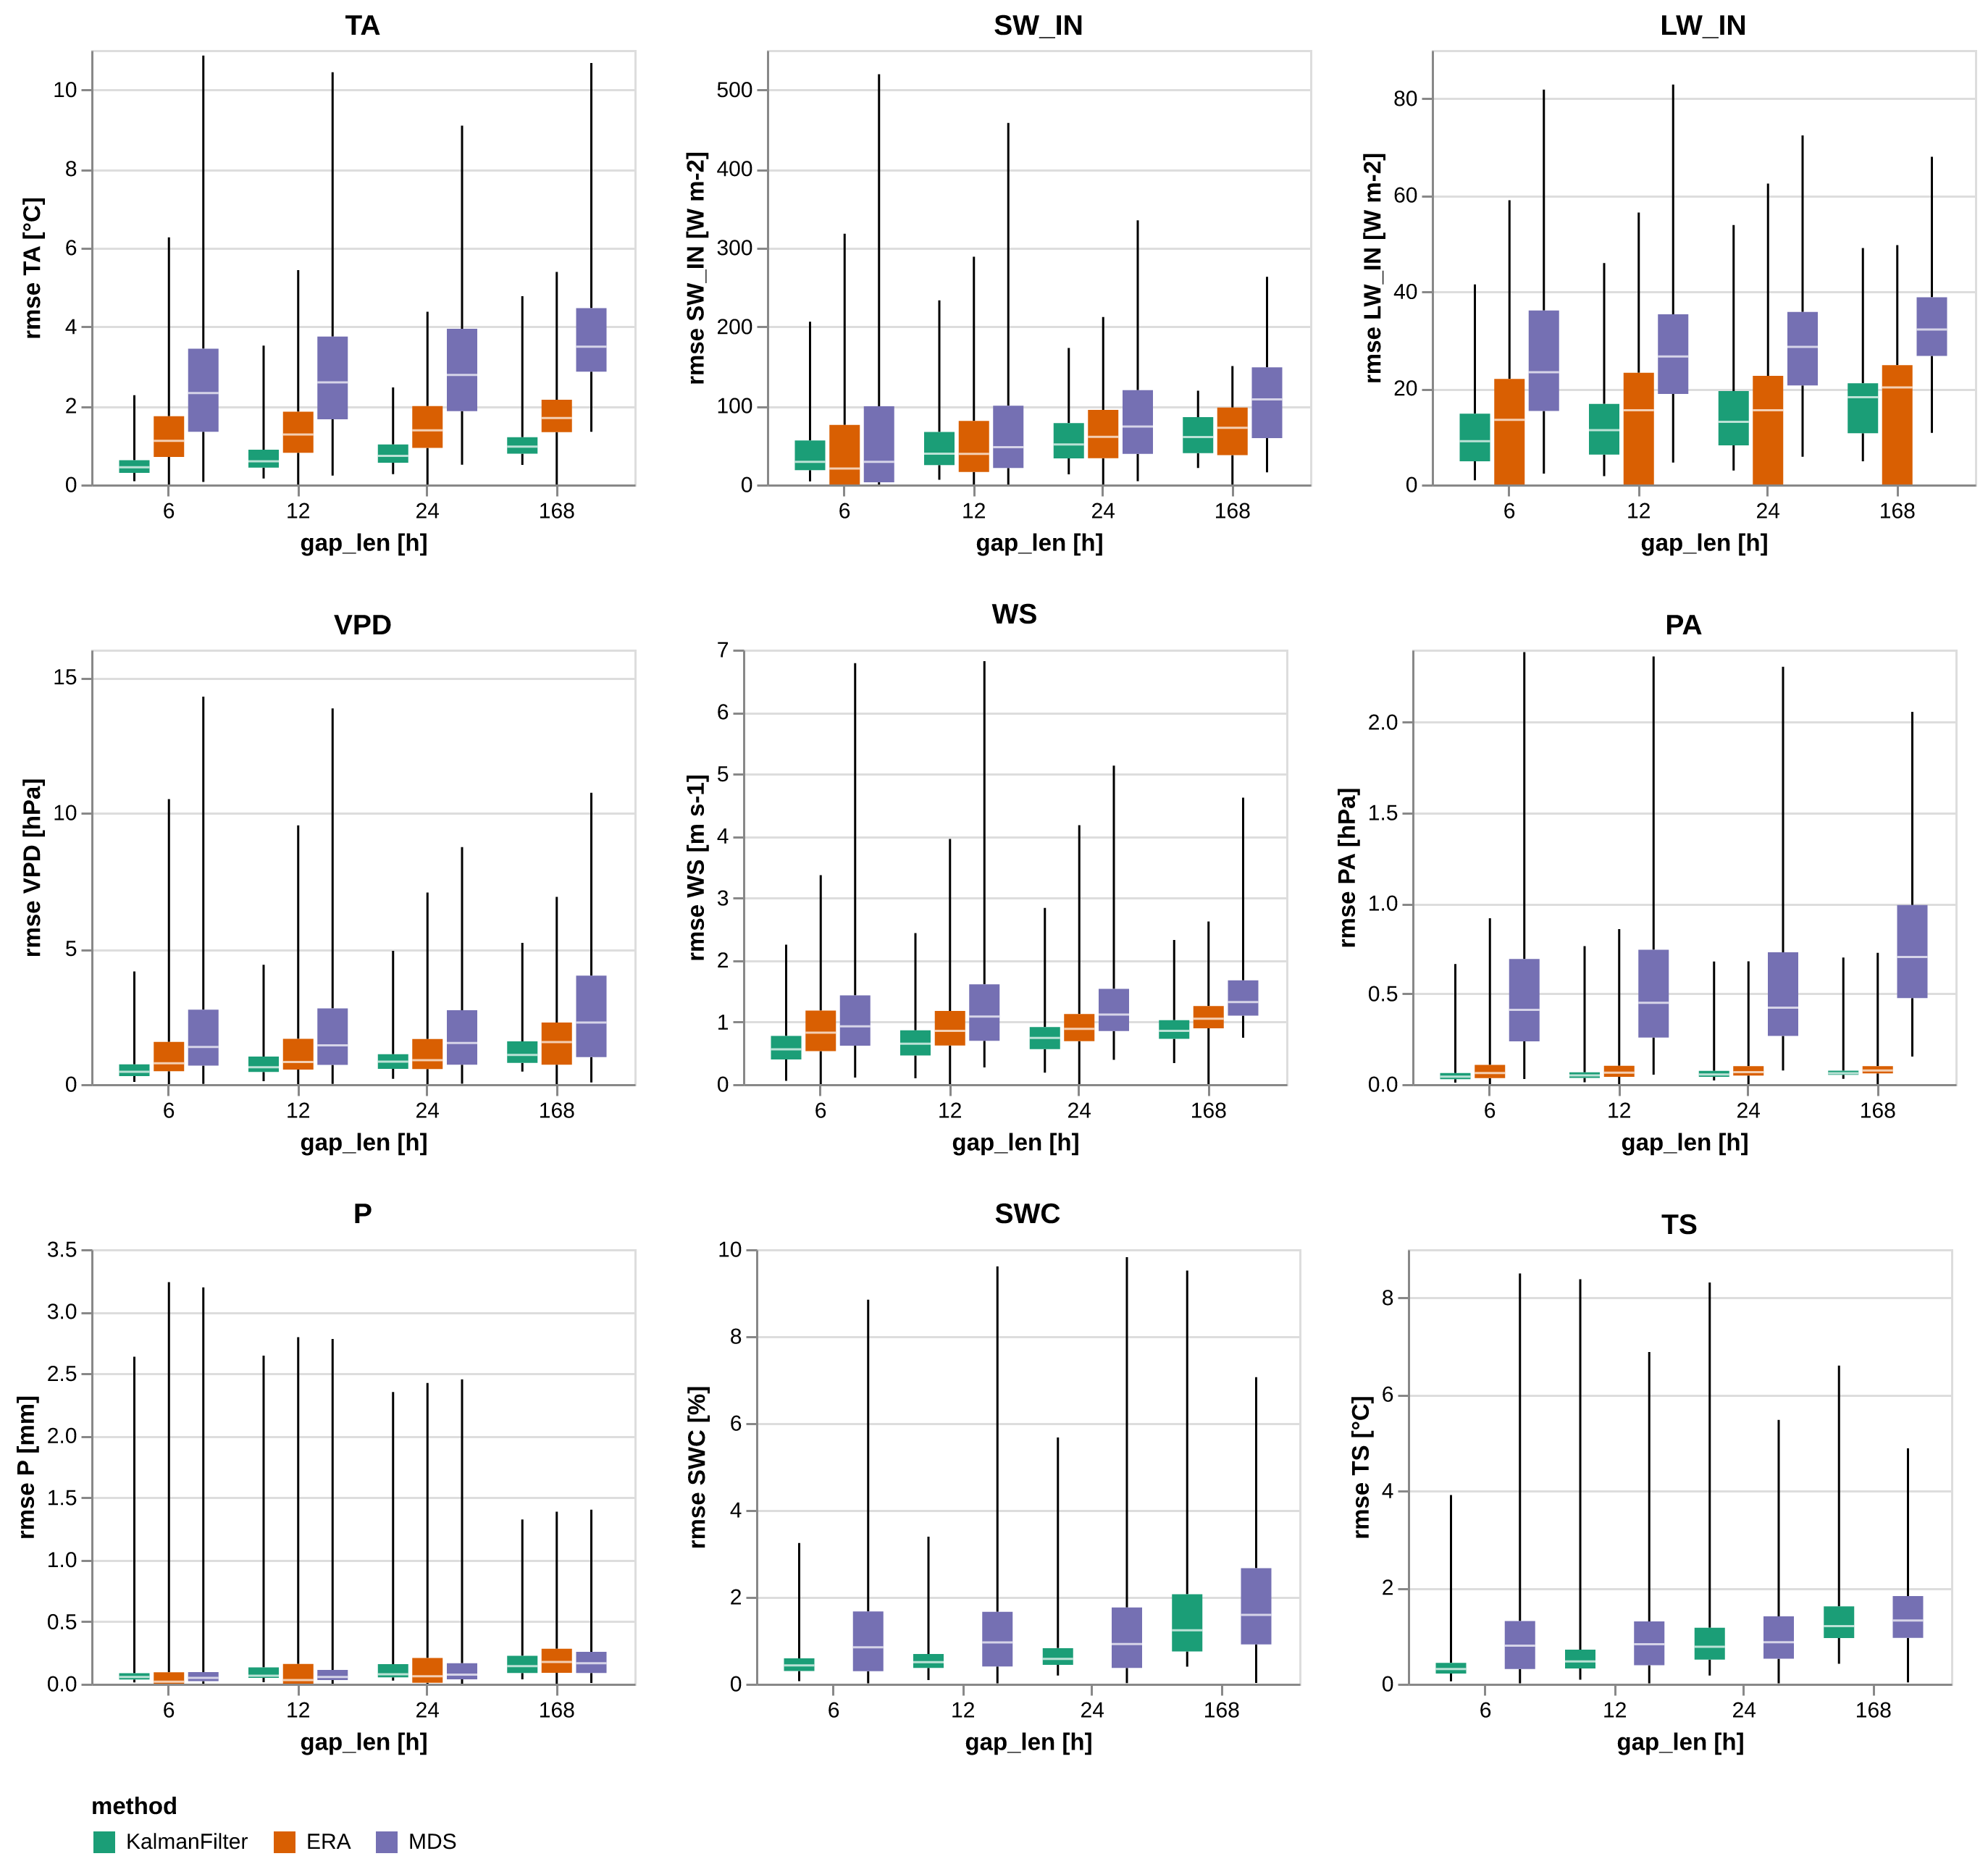

In [ ]:
p = the_plot(results_Av)
save_plot(p, "the_plot")
show_plot("the_plot")

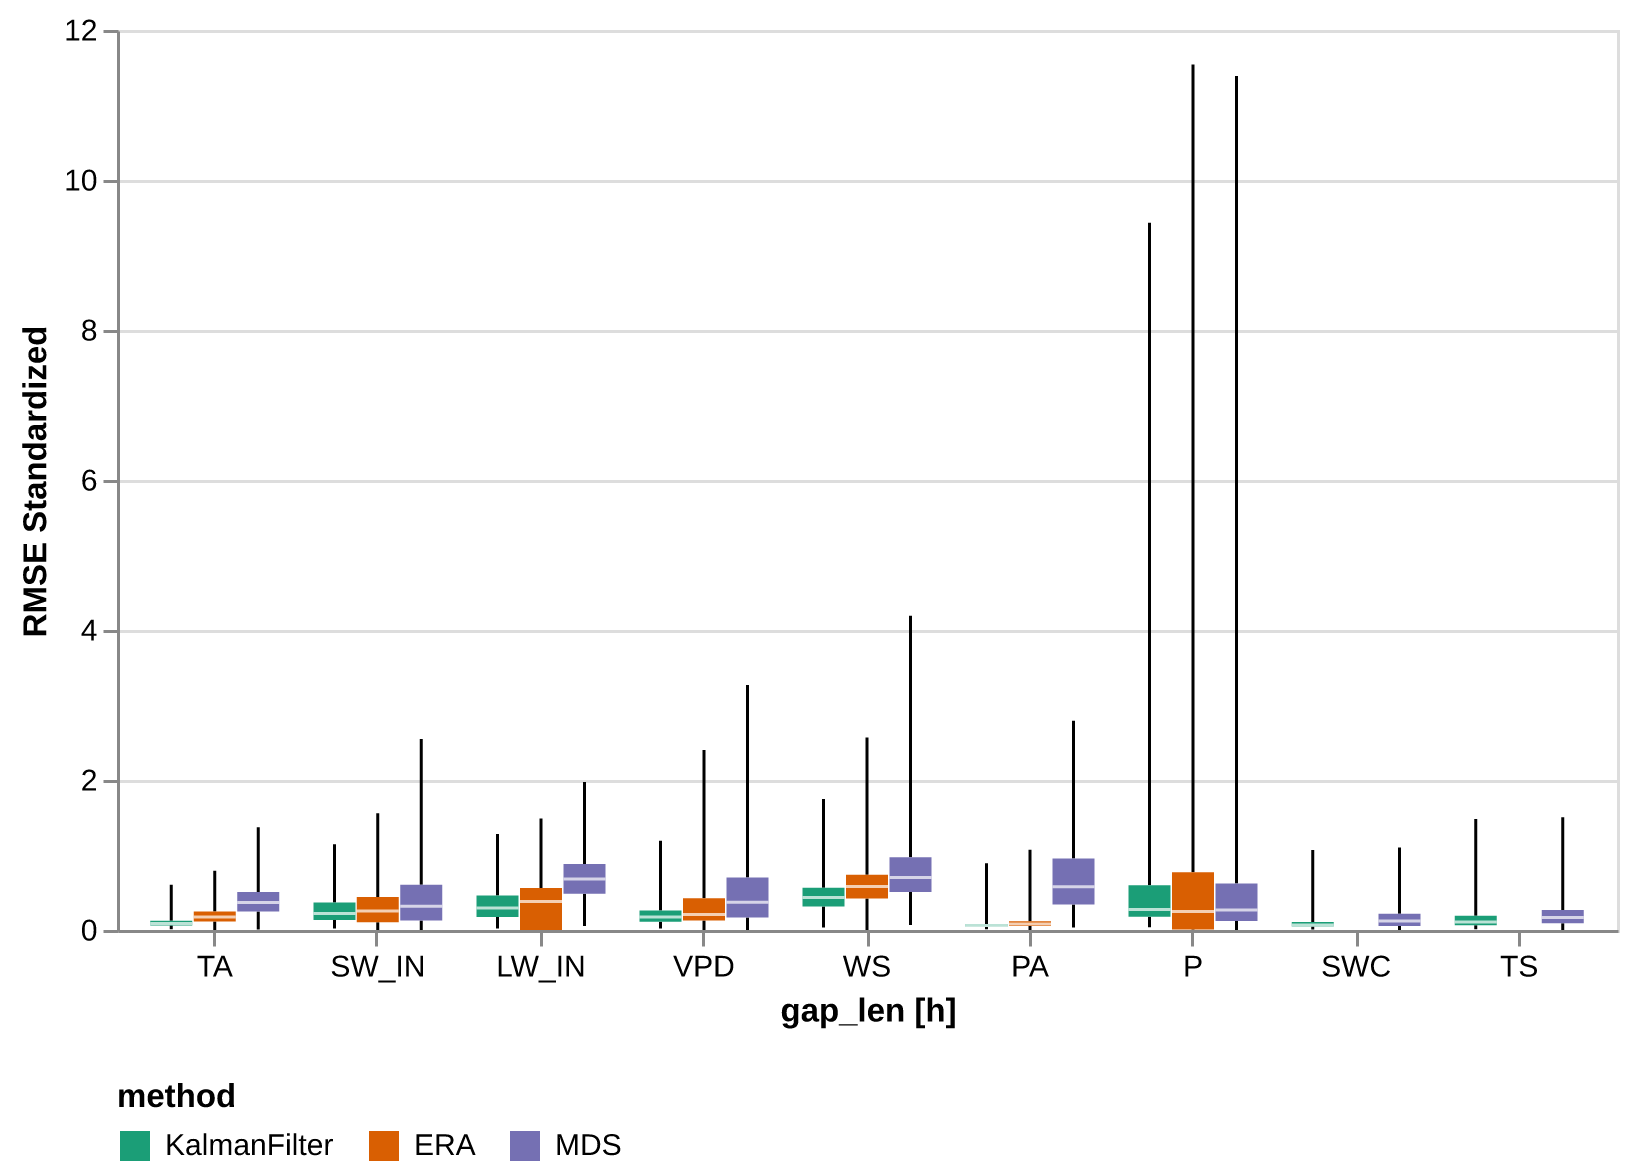

In [ ]:
p = the_plot_stand(results_Av)
save_plot(p, "the_plot_stand")
show_plot("the_plot_stand")

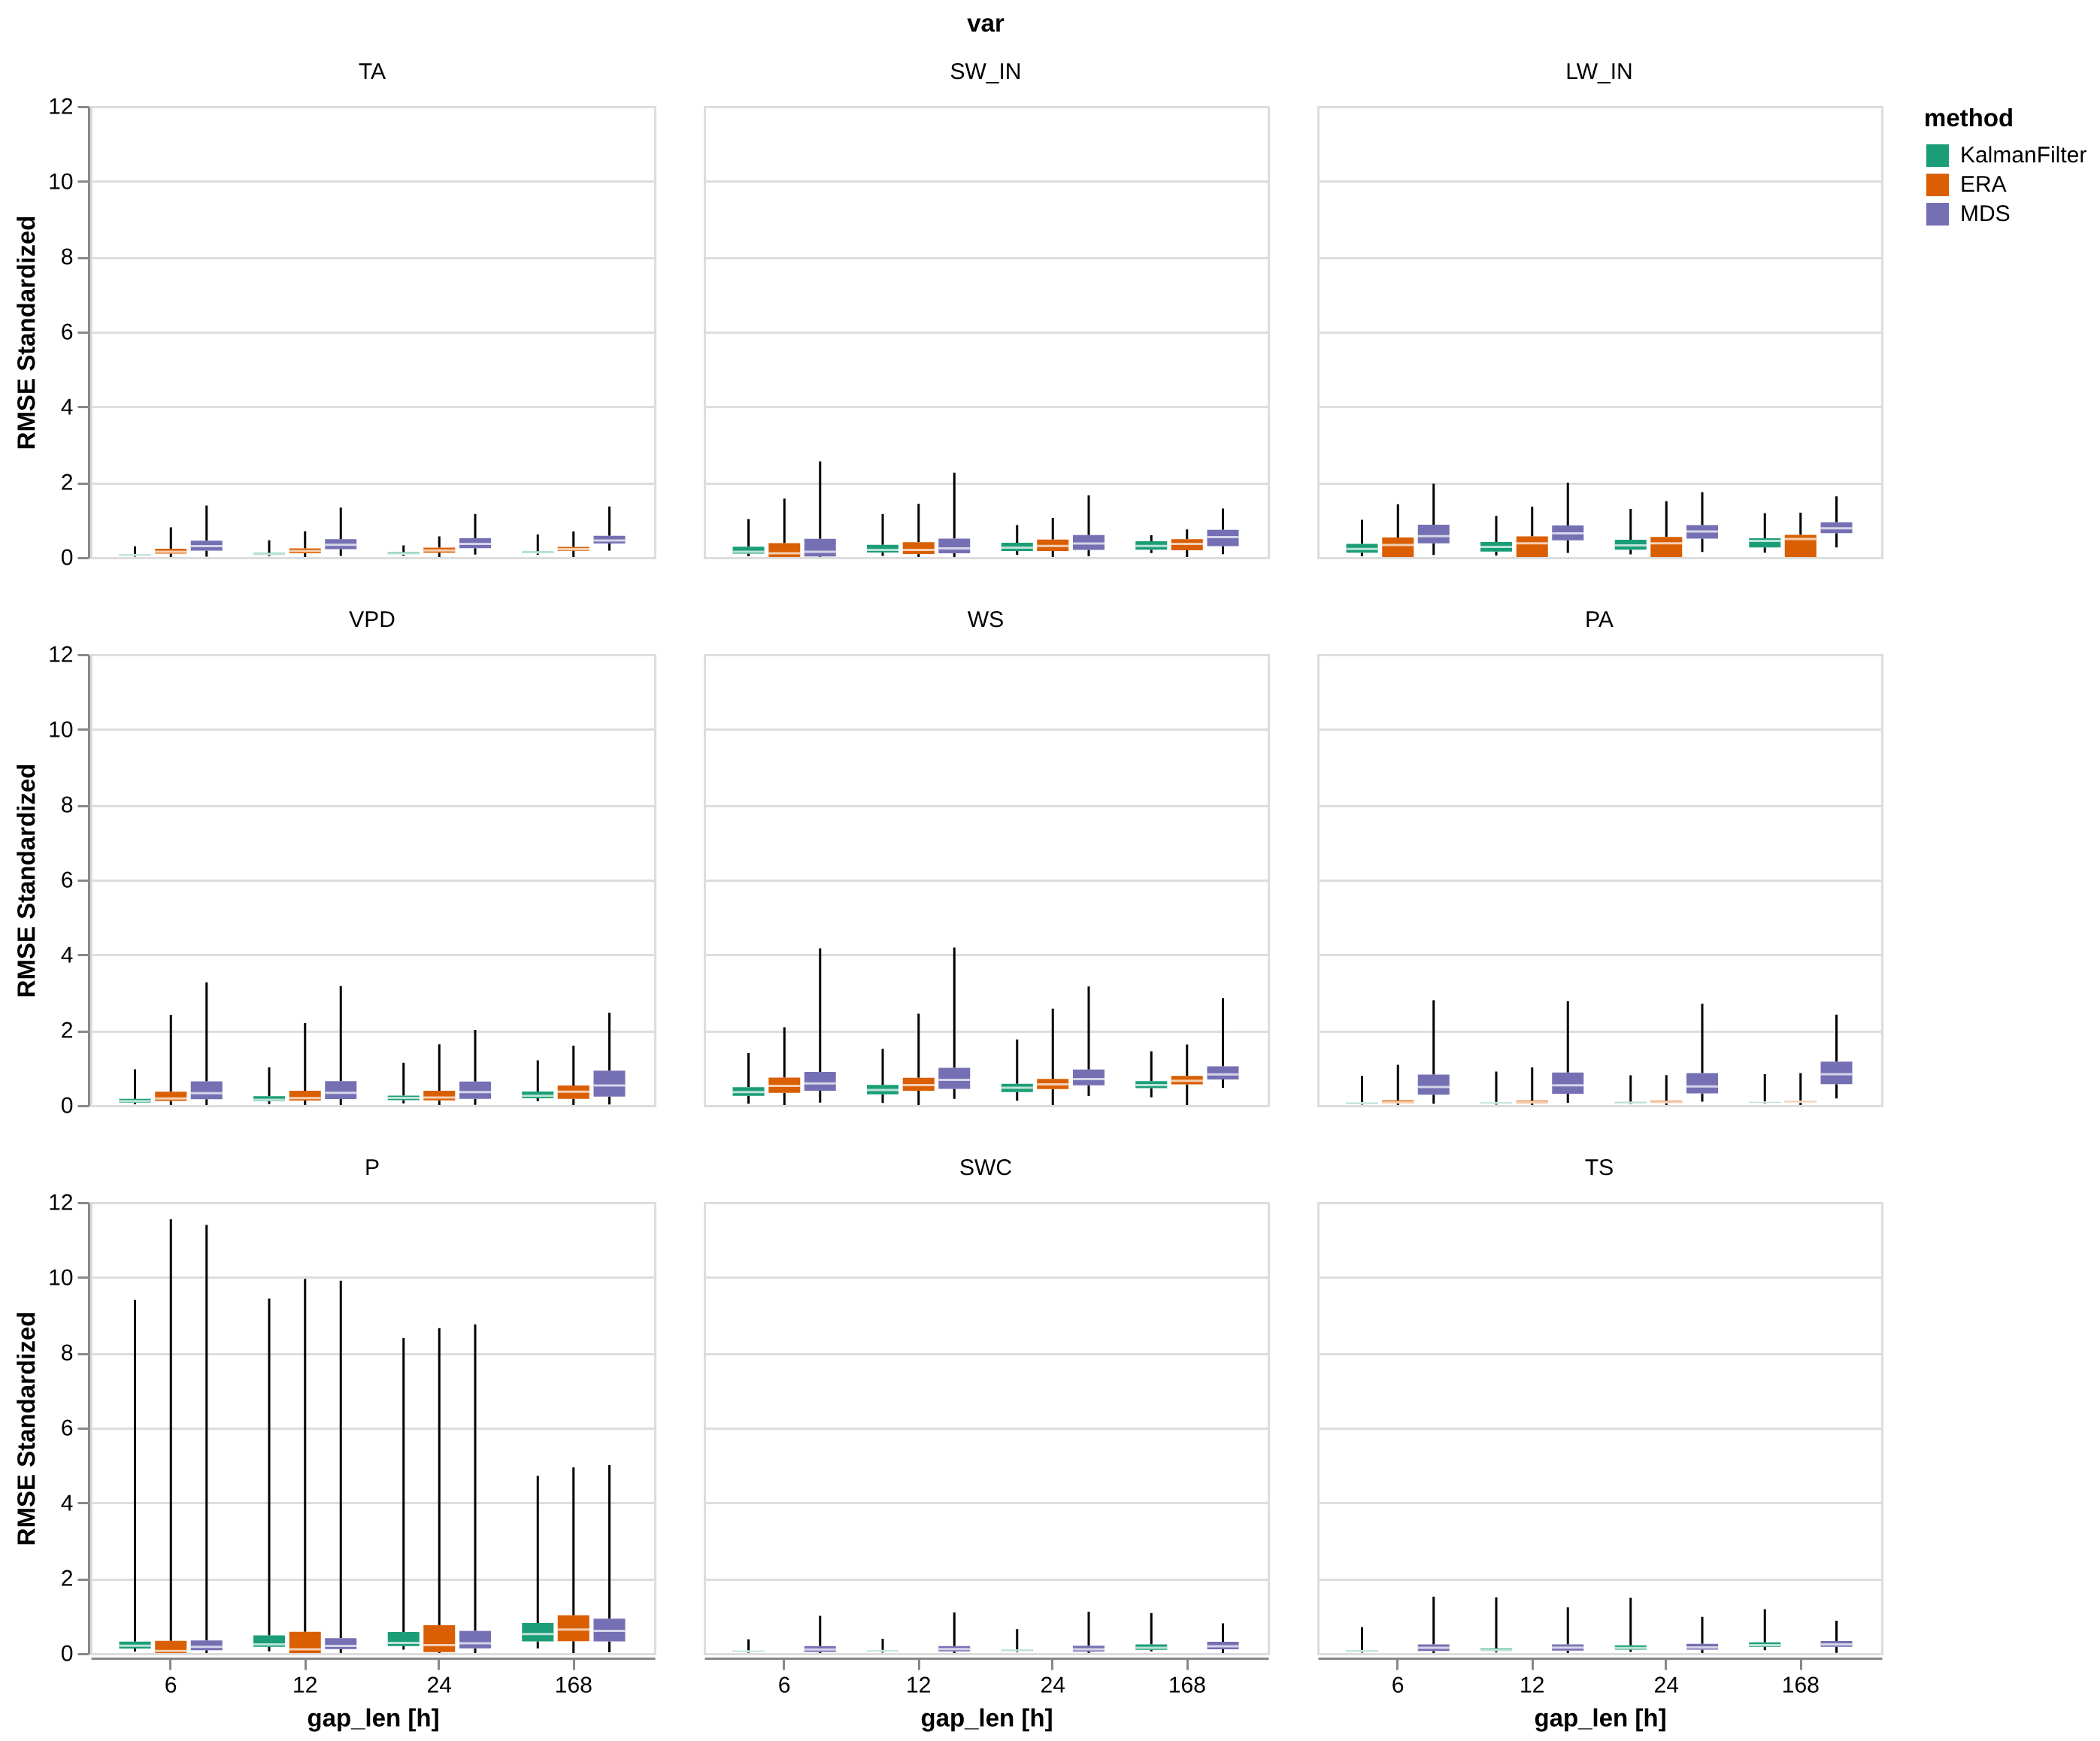

In [ ]:
p = the_plot_stand2(results_Av)
save_plot(p, "the_plot_stand2")
show_plot("the_plot_stand2")

In [ ]:
p = the_plot_stand3(results_Av)
save_plot(p, "the_plot_stand3")
show_plot("the_plot_stand3")

### Table 

In [ ]:
t = the_table(results_Av)
the_table_latex(t, base_path_tbl / "the_table.tex", label="the_table",
                caption="RMSE Comparison imputation methods. The best method for each gap length is highligthed in bold")
t

KalmanFilter                   ERA                    MDS  \
RMSE                       mean        std       mean        std        mean   
Variable Gap [$h$]                                                             
TA       6.0           0.489414   0.286708   1.346910   0.997843    2.712546   
         12.0          0.717705   0.450045   1.471695   0.900611    2.942435   
         24.0          0.846503   0.424666   1.529614   0.800256    3.012819   
         168.0         1.074202   0.465658   1.754334   0.643160    3.780087   
SW_IN    6.0          44.406835  41.185820  49.333113  66.241975   63.536627   
         12.0         49.386211  34.587600  54.207691  49.769296   69.427115   
         24.0         57.888189  29.905625  65.950367  40.930505   86.770917   
         168.0        62.929765  25.382879  70.224393  34.883199  107.384249   
LW_IN    6.0          10.933181   8.117911  13.804628  12.987987   26.680077   
         12.0         12.976946   8.420187  14.766929  12.584725   28.085478   
         24.0         14.311389   8.301348  14.093052  12.227900   29.614461   
         168.0        16.982041   6.724037  16.365697  11.129569   32.954558   
VPD      6.0           0.579836   0.454156   1.296787   1.547397    2.083592   
         12.0          0.830825   0.620231   1.265213   1.288794    2.136626   
         24.0          0.957941   0.616140   1.247527   1.032319    1.912472   
         168.0         1.282954   0.735500   1.662069   1.127314    2.661345   
WS       6.0           0.604378   0.309739   0.912428   0.508295    1.136367   
         12.0          0.701851   0.335770   0.956550   0.524247    1.261203   
         24.0          0.786750   0.333186   0.949427   0.446912    1.275665   
         168.0         0.946239   0.337541   1.088887   0.348541    1.494891   
PA       6.0           0.048172   0.039004   0.074856   0.061726    0.530665   
         12.0          0.054868   0.044319   0.077328   0.058476    0.563603   
         24.0          0.061694   0.040415   0.079021   0.051491    0.556899   
         168.0         0.067441   0.047825   0.083628   0.053654    0.773143   
P        6.0           0.111547   0.253684   0.113173   0.315504    0.117710   
         12.0          0.134660   0.248484   0.138729   0.297227    0.130442   
         24.0          0.156399   0.242352   0.165750   0.288432    0.158641   
         168.0         0.195263   0.175225   0.222682   0.201782    0.214975   
SWC      6.0           0.509564   0.363343        NaN        NaN    1.313730   
         12.0          0.610184   0.439400        NaN        NaN    1.278001   
         24.0          0.755764   0.582507        NaN        NaN    1.355740   
         168.0         1.592585   1.258741        NaN        NaN    1.947605   
TS       6.0           0.372636   0.333516        NaN        NaN    0.954469   
         12.0          0.611555   0.645607        NaN        NaN    1.002555   
         24.0          0.916664   0.733149        NaN        NaN    1.078373   
         168.0         1.401425   0.800632        NaN        NaN    1.440008   

                               
RMSE                      std  
Variable Gap [$h$]             
TA       6.0         1.896914  
         12.0        1.748131  
         24.0        1.611311  
         168.0       1.315472  
SW_IN    6.0        85.401585  
         12.0       68.936352  
         24.0       59.603564  
         168.0      53.606111  
LW_IN    6.0        15.022366  
         12.0       13.457335  
         24.0       12.416763  
         168.0       8.833972  
VPD      6.0         2.149288  
         12.0        2.095549  
         24.0        1.605013  
         168.0       1.965431  
WS       6.0         0.783146  
         12.0        0.796744  
         24.0        0.608630  
         168.0       0.615371  
PA       6.0         0.441476  
         12.0        0.427426  
         24.0        0.404451  
         168.0       0.384029  
P        6.0         0.305539  
  

In [ ]:
t = the_table(results_Av, 'rmse_stand')
the_table_latex(t, base_path_tbl / "the_table_stand.tex", stand = True, label="the_table_stand", 
                caption = "Comparison of imputation methods using Standardized RMSE. The best method for each gap length is highligthed in bold")
t

KalmanFilter                 ERA                 MDS  \
RMSE                       mean       std      mean       std      mean   
Variable Gap [$h$]                                                        
TA       6.0           0.061759  0.036179  0.169965  0.125917  0.342294   
         12.0          0.090567  0.056791  0.185712  0.113647  0.371303   
         24.0          0.106819  0.053588  0.193021  0.100984  0.380185   
         168.0         0.135553  0.058761  0.221378  0.081160  0.477006   
SW_IN    6.0           0.217678  0.201889  0.241826  0.324711  0.311450   
         12.0          0.242086  0.169545  0.265721  0.243964  0.340325   
         24.0          0.283762  0.146594  0.323282  0.200637  0.425342   
         168.0         0.308475  0.124424  0.344233  0.170994  0.526387   
LW_IN    6.0           0.260588  0.193487  0.329028  0.309564  0.635910   
         12.0          0.309301  0.200692  0.351964  0.299952  0.669407   
         24.0          0.341107  0.197860  0.335903  0.291448  0.705850   
         168.0         0.404761  0.160265  0.390071  0.265269  0.785460   
VPD      6.0           0.132734  0.103964  0.296855  0.354224  0.476967   
         12.0          0.190189  0.141981  0.289627  0.295025  0.489108   
         24.0          0.219288  0.141044  0.285579  0.236314  0.437795   
         168.0         0.293689  0.168368  0.380474  0.258060  0.609224   
WS       6.0           0.371828  0.190559  0.561347  0.312715  0.699120   
         12.0          0.431795  0.206574  0.588492  0.322529  0.775922   
         24.0          0.484027  0.204984  0.584110  0.274951  0.784819   
         168.0         0.582148  0.207663  0.669909  0.214431  0.919692   
PA       6.0           0.056331  0.045611  0.087534  0.072180  0.620545   
         12.0          0.064161  0.051826  0.090425  0.068381  0.659061   
         24.0          0.072144  0.047260  0.092405  0.060212  0.651223   
         168.0         0.078864  0.055925  0.097793  0.062741  0.904092   
P        6.0           0.397991  0.905123  0.403790  1.125691  0.419979   
         12.0          0.480457  0.886571  0.494974  1.060481  0.465404   
         24.0          0.558019  0.864691  0.591382  1.029100  0.566018   
         168.0         0.696682  0.625189  0.794512  0.719941  0.767011   
SWC      6.0           0.057170  0.040765       NaN       NaN  0.147393   
         12.0          0.068459  0.049298       NaN       NaN  0.143384   
         24.0          0.084792  0.065354       NaN       NaN  0.152106   
         168.0         0.178679  0.141223       NaN       NaN  0.218510   
TS       6.0           0.065853  0.058939       NaN       NaN  0.168674   
         12.0          0.108074  0.114092       NaN       NaN  0.177172   
         24.0          0.161994  0.129563       NaN       NaN  0.190571   
         168.0         0.247661  0.141488       NaN       NaN  0.254479   

                              
RMSE                     std  
Variable Gap [$h$]            
TA       6.0        0.239370  
         12.0       0.220595  
         24.0       0.203330  
         168.0      0.165998  
SW_IN    6.0        0.418630  
         12.0       0.337919  
         24.0       0.292171  
         168.0      0.262772  
LW_IN    6.0        0.358053  
         12.0       0.320751  
         24.0       0.295949  
         168.0      0.210555  
VPD      6.0        0.492006  
         12.0       0.479704  
         24.0       0.367413  
         168.0      0.449918  
WS       6.0        0.481810  
         12.0       0.490176  
         24.0       0.374443  
         168.0      0.378591  
PA       6.0        0.516250  
         12.0       0.499820  
         24.0       0.472953  
         168.0      0.449073  
P        6.0        1.090136  
         12.0       1.003928  
         24.0       0.946414  
         168.0      0.704660  
SWC      6.0        0.174667  
         12.0       0.148434  
         24.0       0.165171  
         168.0      0.166977  
TS      

### Timeseries

In [ ]:
@cache_disk(cache_dir / "the_results_ts")
def get_the_results_ts():
    comp_Av = ImpComparison(models = models_var, df = hai, control = hai_era, block_len = 446, time_series=True, rmse=False)
    results_Av = comp_Av.compare(gap_len = [12,24, 336], var=list(hai.columns), n_rep=4) 
    return results_Av

# results_ts = get_the_results_ts()

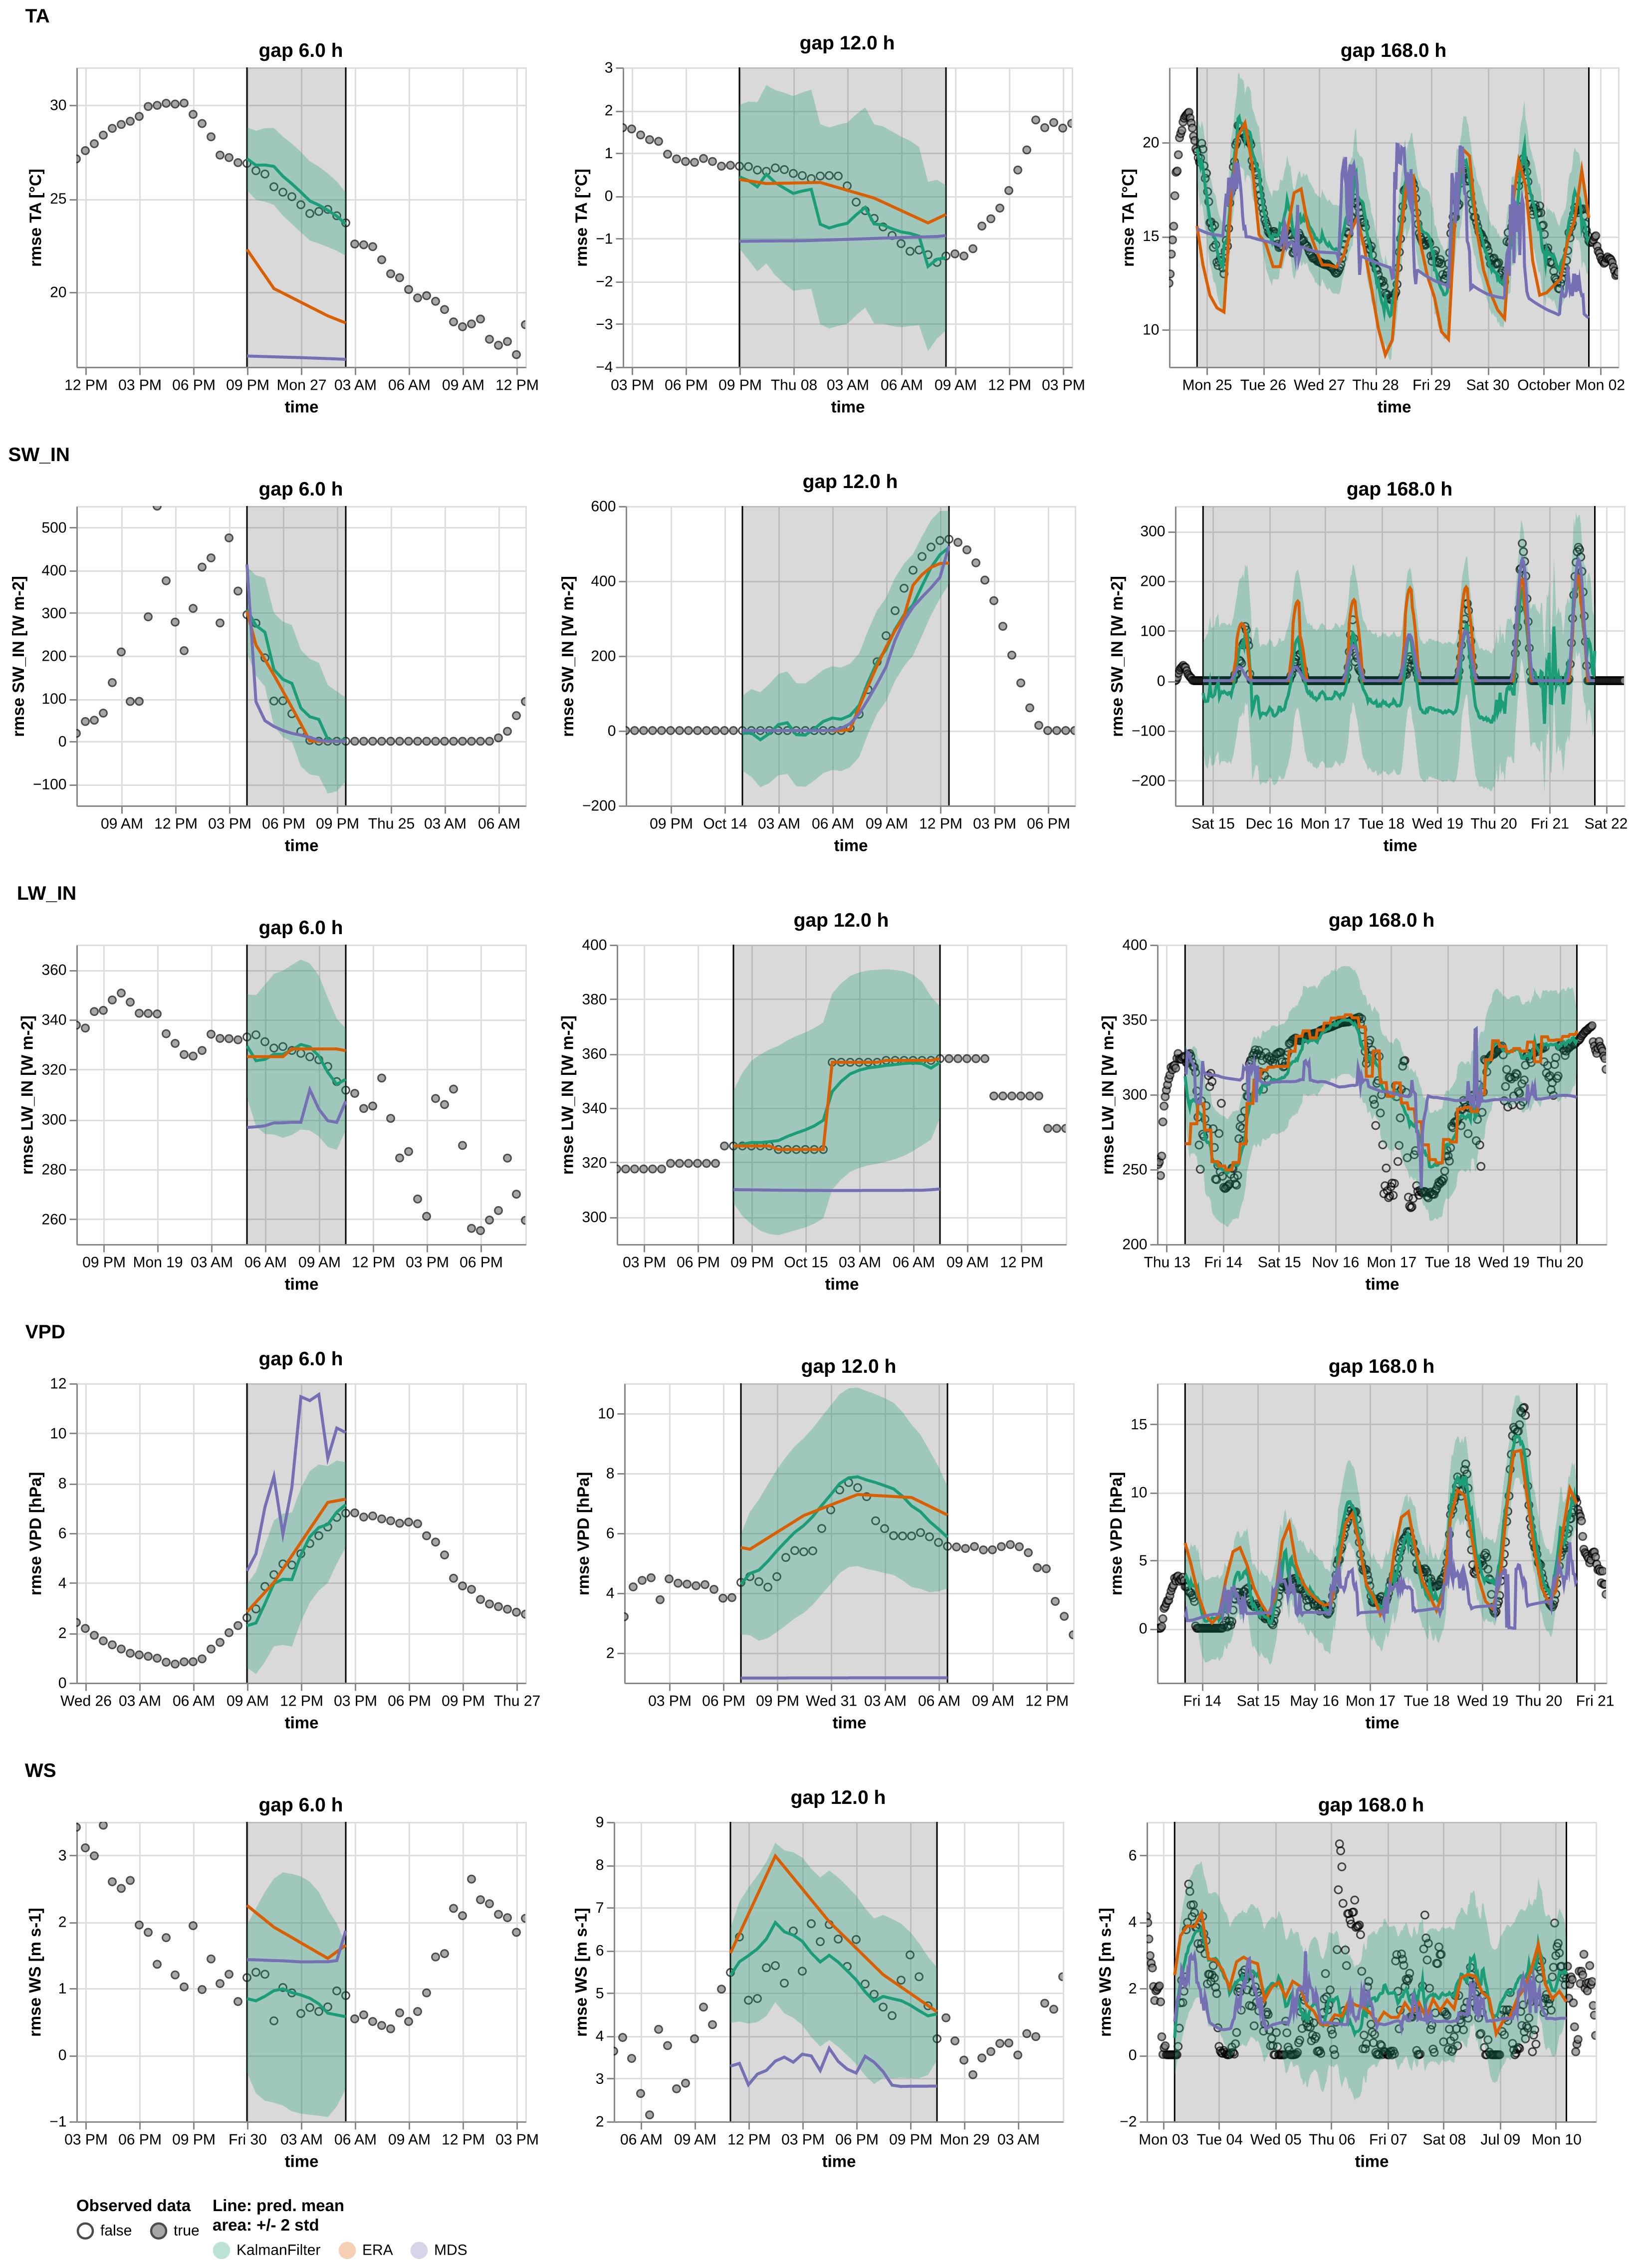

In [ ]:
# ts = plot_timeseries(results_ts.query("var in ['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS']"), idx_rep=0)
# save_plot(ts, "timeseries_1")
show_plot("timeseries_1")

In [ ]:
# %time ts = plot_timeseries(results_ts.query("var in ['PA', 'P', 'TS', 'SWC']"), idx_rep=0)
# %time save_plot(ts, "timeseries_2")
show_plot("timeseries_2")

In [ ]:
from tqdm.auto import tqdm

In [ ]:
results_ts.idx_rep.unique()

In [ ]:
# @cache_disk(cache_dir / "ts_plot")
def plot_additional_ts():
    for idx in tqdm(results_ts.idx_rep.unique()):
        if idx == 0: continue # skip first plot as is done above
        ts1 = plot_timeseries(results_ts.query("var in ['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS']"), idx_rep=idx)
        save_plot(ts1, f"timeseries_1_{idx}")
        ts2 = plot_timeseries(results_ts.query("var in ['PA', 'P', 'TS', 'SWC']"), idx_rep=idx)
        save_plot(ts2, f"timeseries_2_{idx}")        

In [ ]:
# plot_additional_ts()

## Kalman Filter analysis

### Gap len

In [ ]:
@cache_disk("gap_len")
def get_g_len(n_rep=n_rep):
    return KalmanImpComparison(models_var, hai, hai_era, block_len=48*7+100).compare(gap_len = [2,6,12,24,48,48*2, 48*3, 48*7], var=list(hai.columns), n_rep=n_rep)

In [ ]:
gap_len = get_g_len(n_rep)

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
p = plot_gap_len(gap_len, hai, hai_era)
save_plot(p, "gap_len")
p

alt.VConcatChart(...)

In [ ]:
t = table_gap_len(gap_len)
table_gap_len_latex(t, base_path_tbl / "gap_len.tex", label="gap_len",
                caption="RMSE Comparison Kalman filter for different gap lengths")
t

1          3          6         12         24  \
Variable RMSE                                                          
TA       mean   0.249874   0.369584   0.544200   0.721894   0.911514   
SW_IN    mean  27.218983  39.195194  46.166472  50.616872  57.511795   
LW_IN    mean   5.760089   8.424112  12.038032  14.447153  16.137752   
VPD      mean   0.283951   0.430531   0.615616   0.826526   1.098688   
WS       mean   0.349414   0.481933   0.589038   0.705312   0.785513   
PA       mean   0.023761   0.035799   0.047033   0.054201   0.060738   
P        mean   0.061754   0.086840   0.111877   0.145961   0.171795   
SWC      mean   0.250153   0.388866   0.482214   0.585416   0.718911   
TS       mean   0.214781   0.291131   0.394747   0.617634   0.899105   

                      48         72        168  
Variable RMSE                                   
TA       mean   0.996244   1.033084   1.062626  
SW_IN    mean  57.831439  59.806769  60.254291  
LW_IN    mean  16.569009  16.380740  17.414271  
VPD      mean   1.148027   1.219952   1.236631  
WS       mean   0.842590   0.919232   0.921488  
PA       mean   0.069416   0.070363   0.068169  
P        mean   0.163256   0.169645   0.187402  
SWC      mean   0.930457   1.038485   1.533061  
TS       mean   1.084576   1.238317   1.458591

In [ ]:
# with open(base_path_tbl / "gap_len.tex") as f:
    # print(f.readlines())

In [ ]:
from meteo_imp.kalman.results import _get_era_rmse, _plot_gap_len

In [ ]:
data = prep_df(agg_gap_len(gap_len))
data = pd.merge(data, _get_era_rmse(hai, hai_era), on='var', how='left')
data = data[data.method == 'KalmanFilter']
data = data.astype({'gap_len': float})

In [ ]:
data

In [ ]:
data.era_rmse = 3

In [ ]:
data.query("var == 'SWC'")

In [ ]:
_plot_gap_len(data.query("var == 'SWC'"), "")

In [ ]:
p

### Control

In [ ]:
models_nc = pd.DataFrame({'model': [ l_model("1_gap_varying_336_no_control_v1.pickle"), l_model("1_gap_varying_6-336_v3.pickle")],
                          'type':   [ 'No Control',                                       'Use Control'                         ]})                                        

In [ ]:
@cache_disk("use_control")
def get_control(n_rep=n_rep):
    
    kcomp_control = KalmanImpComparison(models_nc, hai, hai_era, block_len=100+48*7)

    k_results_control = kcomp_control.compare(n_rep =n_rep, gap_len = [12, 24, 48, 48*7], var = list(hai.columns))
    
    return k_results_control

In [ ]:
from time import sleep

In [ ]:
sleep( 60 * 60 * 5.5) # wait for other process to finish

In [ ]:
k_results_control = get_control(n_rep)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
k_results_control

In [ ]:
p = plot_compare(k_results_control, 'type', scale_domain=["Use Control", "No Control"])
save_plot(p, "use_control")
p

In [ ]:
from functools import partial

In [ ]:
t = table_compare(k_results_control, 'type')
table_compare_latex(t, base_path_tbl / "control.tex", label="control",
                caption="Comparison between generic model with control variable (Use Control) and generic model without control variable (No Control). 50 samples for each variable and each gap length. The best result for each for each gap length is highligthed in bold")
t

### Gap in Other variables

In [ ]:
models_gap_single = pd.DataFrame.from_records([
    {'Gap':  'All variables',            'gap_single_var': False,  'model': l_model("All_gap_all_30_v1.pickle")  },
    {'Gap':  'Only one var | generic',   'gap_single_var': True,   'model': l_model("1_gap_varying_6-336_v3.pickle")  },
    {'Gap':  'Only one var | fine tuned','gap_single_var': True,   'model': l_model("1_gap_varying_tuned_6-30_v1.pickle")  }
])

In [ ]:
models_gap_single

Gap  gap_single_var  \
0              All variables           False   
1     Only one var | generic            True   
2  Only one var | fine tuned            True   

                                                                                     model  
0  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14  
1  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14  
2  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14

In [ ]:
@cache_disk("multi_gap")
def get_multi_gap(n_rep):
    kcomp_single = KalmanImpComparison(models_gap_single, hai, hai_era, block_len=130)

    return kcomp_single.compare(n_rep =n_rep, gap_len = [6, 12, 24, 30], var = list(hai.columns))

In [ ]:
k_results_single = get_multi_gap(30)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
p = plot_compare(k_results_single, "Gap", scale_domain=["Only one var | fine tuned", "All variables", "Only one var | generic",])
save_plot(p, "gap_single_var")
p

alt.VConcatChart(...)

In [ ]:
k_results_single = get_multi_gap(n_rep)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
k_results_single = get_multi_gap(70)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
t = table_compare(k_results_single, 'Gap')
table_compare_latex(t, base_path_tbl / "gap_single_var.tex")
t

### Generic vs Specialized

In [ ]:
models_generic = models_var.copy()

In [ ]:
models_generic.model = l_model("1_gap_varying_6-336_v3.pickle") 
models_generic['type'] = 'Generic'

In [ ]:
models_generic

var  \
0     TA   
1  SW_IN   
2  LW_IN   
3    VPD   
4     WS   
5     PA   
6      P   
7     TS   
8    SWC   

                                                                                     model  \
0  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
1  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
2  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
3  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
4  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
5  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
6  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
7  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
8  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   

      type  
0  Generic  
1  Generic  
2  Generic  
3  Generic  
4  Generic  
5  Generic  
6  Generic  
7  Generic  
8  Generic

In [ ]:
models_var['type'] = 'Finetuned one var'

In [ ]:
models_gen_vs_spec = pd.concat([models_generic, models_var])

In [ ]:
models_gen_vs_spec

var  \
0     TA   
1  SW_IN   
2  LW_IN   
3    VPD   
4     WS   
5     PA   
6      P   
7     TS   
8    SWC   
0     TA   
1  SW_IN   
2  LW_IN   
3    VPD   
4     WS   
5     PA   
6      P   
7     TS   
8    SWC   

                                                                                     model  \
0  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
1  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
2  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
3  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
4  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
5  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
6  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
7  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
8  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
0  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
1  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
2  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
3  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
4  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
5  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
6  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
7  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   
8  Kalman Filter\n        N dim obs: 9,\n        N dim state: 18,\n        N dim contr: 14   

                type  
0            Generic  
1            Generic  
2            Generic  
3            Generic  
4            Generic  
5            Generic  
6            Generic  
7            Generic  
8            Generic  
0  Finetuned one var  
1  Finetuned one var  
2  Finetuned one var  
3  Finetuned one var  
4  Finetuned one var  
5  Finetuned one var  
6  Finetuned one var  
7  Finetuned one var  
8  Finetuned one var

In [ ]:
@cache_disk("generic")
def get_generic(n_rep=n_rep):

    comp_generic = KalmanImpComparison(models_gen_vs_spec, hai, hai_era, block_len=100+48*7)

    return comp_generic.compare(n_rep =n_rep, gap_len = [12, 24, 48, 48*7], var = list(hai.columns))
k_results_generic = get_generic(n_rep)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
p = plot_compare(k_results_generic, 'type', scale_domain=["Finetuned one var", "Generic"])
save_plot(p, "generic")
p

In [ ]:
t = table_compare(k_results_generic, 'type')
table_compare_latex(t, base_path_tbl / "generic.tex")
t

## Fluxnet

In [ ]:
import polars as pl
from fastai.vision.data import get_grid

### Correlation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm

In [ ]:
def auto_corr_df(data, nlags=48):
    autocorr = {}
    for col in data.columns:
        autocorr[col] = sm.tsa.acf(data[col], nlags=nlags)
    return pd.DataFrame(autocorr)

In [ ]:
auto_corr = auto_corr_df(hai).T[[1,3,6,12,24,48]]
auto_corr.columns = auto_corr.columns /2

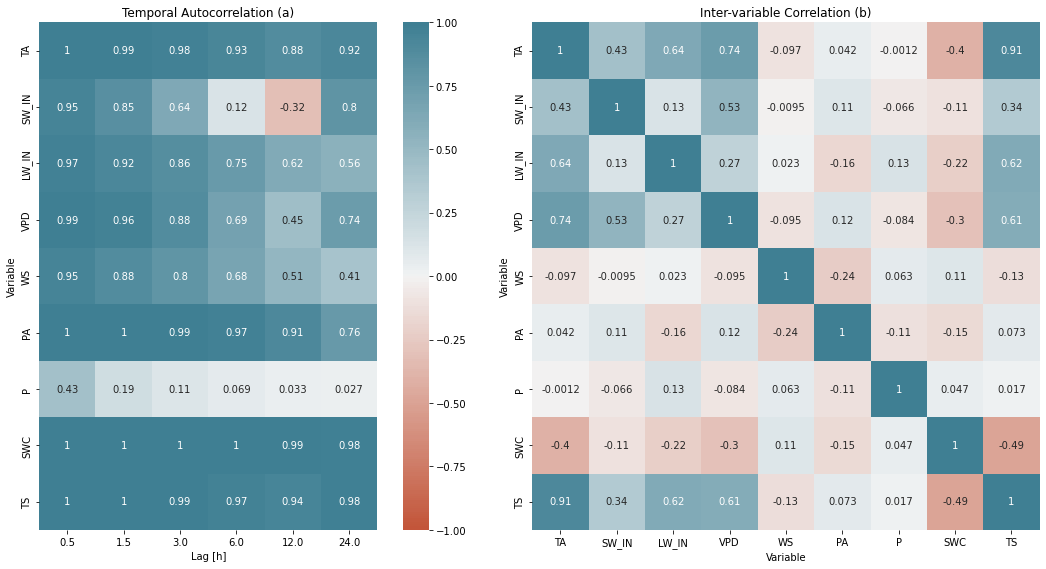

In [ ]:
axes = get_grid(2,1,2, figsize=(15.5,8))
sns.heatmap(hai.corr(), annot=True,     vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), ax=axes[1], square=True, cbar=False)
sns.heatmap(auto_corr, annot=True,     vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), square=True, ax=axes[0], cbar=True)
axes[0].set(ylabel="Variable", xlabel="Lag [h]", title="Temporal Autocorrelation (a)")
axes[1].set(xlabel="Variable", ylabel="Variable", title="Inter-variable Correlation (b)");
plt.tight_layout()
plt.savefig(base_path_img / "correlation.png")

### Gap distribution

In [ ]:
out_dir = here("../fluxnet/gap_stat")

In [ ]:
site_info = pl.read_parquet(out_dir / "../site_info.parquet").select([
    pl.col("start").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M"),
    pl.col("end").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M"),
    pl.col("site").cast(pl.Categorical).sort()
])

In [ ]:
def duration_n_obs(duration):
    "converts a duration into a n of fluxnet observations"
    return abs(int(duration.total_seconds() / (30 * 60)))

In [ ]:
files = out_dir.ls()
files.sort() # need to sort to match the site_info
sites = []
for i, path in enumerate(files):
    sites.append(pl.scan_parquet(path).with_columns([
        pl.lit(site_info[i, "site"]).alias("site"),
        pl.lit(duration_n_obs(site_info[i, "start"] -  site_info[i, "end"])).alias("total_obs"),
        pl.col("TIMESTAMP_END").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M").alias("end"),
    ]).drop("TIMESTAMP_END"))

gap_stat = pl.concat(sites)

In [ ]:
def plot_var_dist(var, small=False, ax=None):
    if ax is None: ax = get_grid(1)[0]
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var)
    ).filter(
        pl.col("gap_len") < 200 if small else True
    ).with_column(pl.col("gap_len") / (24 *2 * 7)).collect().to_pandas().hist("gap_len", bins=50, ax=ax)
    ax.set_title(f"{var} - { 'gaps < 200' if small else 'all gaps'}")
    if not small: ax.set_yscale('log')
    ax.set_xlabel("gap length (weeks)")
    ax.set_ylabel(f"{'Log' if not small else ''} n gaps")
    # plt.xscale('log') 

In [ ]:
plot_var_dist('TA_F_QC')

In [ ]:
color_map = dict(zip(scale_meteo.domain, list(sns.color_palette('Set2', n_colors=len(hai.columns)).as_hex())))

In [ ]:
qc_map = {
    'TA': 'TA_F_QC',
    'SW_IN': 'SW_IN_F_QC',
    'LW_IN': 'LW_IN_F_QC',
    'VPD': 'VPD_F_QC',
    'WS': 'WS_F_QC',
    'PA': 'PA_F_QC',
    'P': 'P_F_QC',
    'TS': 'TS_F_MDS_1_QC',
    'SWC': 'SWC_F_MDS_1_QC',
}

In [ ]:
def pl_in(col, values):
    expr = False
    for val in values:
        expr |= pl.col(col) == val
    return expr

In [ ]:
gap_stat.filter(pl_in('variable', qc_map.values())
               ).with_columns([
    pl.when(pl.col("gap_len") < 48*7).then(True).otherwise(False).alias("short"),
    pl.count().alias("total"),
    pl.count().alias("total len"),
]).groupby("short").agg([
    (pl.col("gap_len").count() / pl.col("total")).alias("frac_num"),
    (pl.col("gap_len").sum() / pl.col("total len")).alias("frac_len")
]).collect()

In [ ]:
def plot_var_dist_small(var, ax=None, small=True):
    if ax is None: ax = get_grid(1)[0]
    
    color = color_map[var]
    var_qc = qc_map[var]
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var_qc)
    ).filter(
        pl.col("gap_len") < (24 * 2 *7) if small else True 
    ).with_column(pl.col("gap_len") / (2 if small else 48 * 7)
                 ).collect().to_pandas().hist("gap_len", bins=50, ax=ax, edgecolor="white", color=color)
    ax.set_title(f"{var} - { 'gap length <  1 week' if small else 'all gaps'}")
    ax.set_xlabel(f"gap length ({ 'hour' if small else 'week'})")
    ax.set_ylabel(f"Log n gaps")
    ax.set_yscale('log') 

In [ ]:
vars = gap_stat.select(pl.col("variable").unique()).collect()

In [ ]:
vars.filter(pl.col("variable").str.contains("TA"))

In [ ]:
for ax, var in zip(get_grid(9,3,3, figsize=(15,12), sharey=False), list(var_type.categories)):
    plot_var_dist_small(var, ax=ax)
plt.savefig(base_path_img / "gap_len_dist_small.png")

In [ ]:
for ax, var in zip(get_grid(9,3,3, figsize=(15,12), sharey=False), list(var_type.categories)):
    plot_var_dist_small(var, ax=ax, small=False)
plt.savefig(base_path_img / "gap_len_dist.png")

methods colors

In [ ]:
print(sns.color_palette('Dark2').as_hex())